# Evaluation of GRN inference methods
## Processing results
### by Jalil Nourisa



# Imports

In [1]:
# Reload and autoreload settings for modules
%reload_ext autoreload
%autoreload 2

# Import necessary libraries
import os
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import sys
import numpy as np
import json
from scipy.stats import pearsonr
from pandas.api.types import CategoricalDtype
import seaborn
import matplotlib
from matplotlib.gridspec import GridSpec
import warnings
from grn_benchmark.src.helper import load_env
env = load_env()
# Suppress warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set plot parameters
plt.rcParams['font.family'] = 'Arial'  # Arial or 'Liberation Sans'
default_font = matplotlib.rcParams['font.family']
print(default_font)

# Add the src folder to the path
sys.path.insert(0, '../')
from src.helper import surrogate_names, colors_blind, palette_celltype, palette_methods, \
        DATASETS, plot_heatmap, \
        read_yaml

TASK_GRN_INFERENCE_DIR = env['TASK_GRN_INFERENCE_DIR']
sys.path.insert(0, TASK_GRN_INFERENCE_DIR)
from src.utils.config import METHODS, METRICS, FINAL_METRICS

# Set paths for task grn inference
results_folder = f'{TASK_GRN_INFERENCE_DIR}/resources/results'
scores_dir = f'{results_folder}/'
models = ['celloracle', 'grnboost', 'pearson_corr', 'positive_control', 'negative_control',
            'scenicplus','granie','figr','scglue','scenic','ppcor', 'portia', 'spearman_corr', 'scgpt', 'geneformer']

%matplotlib inline

['Arial']


In [2]:
def plot_raw_scores(scores, ax):
    scores_dir = scores.set_index('model').drop(columns='dataset')
    scores = scores.dropna(how='all', axis=1)
    
    scores = scores[[c for c in METRICS if c in scores.columns]]
    scores.columns = scores.columns.map(lambda name: surrogate_names.get(name, name))
    scores.index = scores.index.map(lambda name: surrogate_names.get(name, name))
    scores = scores.astype(float)
    ranks = scores.rank(axis=0, ascending=False, method='min')
    scores['_overall_rank'] = ranks.mean(axis=1, skipna=True)
    scores = scores.sort_values(by='_overall_rank').drop(columns=['_overall_rank'])
    plot_heatmap(scores, name='', ax=ax, cmap="viridis")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
    ax.set_ylabel('')
    return scores_mat.index
def process_trace_func(trace):
    cols = ['%cpu', 'peak_rss', 'peak_vmem', 'rchar', 'wchar']
    datasets = DATASETS
    t_store = []
    for model in METHODS:
        for i, row in trace.iterrows():
            if f'{model}_process' in row['name']:
                t = trace.loc[[i], cols]
                t['model'] = model

                for dataset in datasets:
                    if dataset in row['name']:
                        t['dataset'] = dataset
                        t_store.append(t)
                        break
    if len(t_store) == 0:
        print("trace file has not model process info -> skipping processing")
        return pd.DataFrame()
    trace_df = pd.concat(t_store).reset_index()
    if True:
        # Conversion factors
        unit_to_bytes = {
            "KB": 1024,
            "MB": 1024**2,
            "GB": 1024**3,
            "B": 1
        }

        def convert_to_gb(value):
            if pd.isna(value):
                return None
            value = str(value).strip()
            try:
                num, unit = value.split()
                num = float(num)
                unit = unit.upper()
                if unit in unit_to_bytes:
                    return num * unit_to_bytes[unit] / (1024**3)  # convert bytes → GB
                else:
                    return float(num)  # fallback if no unit
            except Exception:
                return None

        # - remove GB and MB from the columns
        # Apply conversion
        for col in ["peak_rss", "peak_vmem", "rchar", "wchar"]:
            trace_df[col] = trace_df[col].apply(convert_to_gb)

        # Rename columns with consistent units
        for col in ["%cpu"]:
            trace_df[col] = trace_df[col].str.replace(r"[^0-9.]", "", regex=True).astype(float)

        trace_df.rename(
            columns={
                "%cpu": "CPU Usage (%)",
                "peak_rss": "Peak RSS (GB)",
                "peak_vmem": "Peak VMem (GB)",
                "rchar": "Read Chars (GB)",
                "wchar": "Written Chars (GB)"
            },
            inplace=True
        )
        trace_df = trace_df.round(2)
    
    return trace_df

# GRN inference and evaluation

GRN inference and evaluation are two seperate pipelines. Download and install https://github.com/openproblems-bio/task_grn_inference, then:
Inside `scripts/run_all.sh`, select the relevant step. GRN inference is very computational intensive.

In [30]:
for dataset in DATASETS:
    !aws s3 sync s3://openproblems-data/resources/grn/results/$dataset {results_folder}/$dataset --exclude "*" --include "*.yaml" --include "*.txt" --include "*.csv"

download: s3://openproblems-data/resources/grn/results/op/trace_merged.txt to ../../task_grn_inference/resources/results/op/trace_merged.txt
download: s3://openproblems-data/resources/grn/results/parsebioscience/trace_merged.txt to ../../task_grn_inference/resources/results/parsebioscience/trace_merged.txt
download: s3://openproblems-data/resources/grn/results/parsebioscience/trace_merged.txt to ../../task_grn_inference/resources/results/parsebioscience/trace_merged.txt
download: s3://openproblems-data/resources/grn/results/300BCG/trace_merged.txt to ../../task_grn_inference/resources/results/300BCG/trace_merged.txt
download: s3://openproblems-data/resources/grn/results/300BCG/trace_merged.txt to ../../task_grn_inference/resources/results/300BCG/trace_merged.txt
download: s3://openproblems-data/resources/grn/results/ibd_uc/trace_merged.txt to ../../task_grn_inference/resources/results/ibd_uc/trace_merged.txt
download: s3://openproblems-data/resources/grn/results/ibd_uc/trace_merged.txt

In [42]:
# !cd {TASK_GRN_INFERENCE_DIR} && bash src/local_workflows/run_evaluation.sh --no_run_consensus --run_metrics 
!cd {TASK_GRN_INFERENCE_DIR} && bash src/local_workflows/run_evaluation.sh --process_results 

GRN Evaluation Configuration
Run consensus: false
Run metrics: false
Output directory: output/evaluation
Results file: resources/results/all_scores.csv
Process results: true
Number of workers: 20
Generating dataset configuration...
Config file generated at: src/utils/dataset_config.env
Datasets to evaluate: norman

Processing Results
Looking for score files in: output/evaluation
Will save results to: resources/results/all_scores.csv
Known datasets: ['op', 'parsebioscience', '300BCG', 'ibd_uc', 'ibd_cd']...
Processed: xaira_HEK293T - grnboost (53 metrics)
Processed: op - negative_control (47 metrics)
Processed: ibd_cd - scgpt (45 metrics)
Processed: ibd_cd - negative_control (45 metrics)
Processed: ibd_cd - portia (45 metrics)
Processed: 300BCG - pearson_corr (47 metrics)
Processed: parsebioscience - scenic (47 metrics)
Processed: replogle - positive_control (53 metrics)
Processed: ibd_uc - scgpt (45 metrics)
Processed: ibd_cd - pearson_corr (45 metrics)
Processed: parsebioscience - scp

# Scores datasets

In [ ]:
output_dir = f"{RESULTS_DIR}/experiment/metrics_applicibility"
!cd ../ && python src/stability_analysis/metrics_applicibility/script.py --cv_threshold 0.2 --output {output_dir} --local_run

In [45]:
# - this code assembles indivudual runs for final results
# !python {TASK_GRN_INFERENCE_DIR}/src/process_data/process_trace_files.py --input_base {results_folder}

op
parsebioscience
300BCG
ibd_uc
ibd_cd
replogle
xaira_HEK293T
xaira_HCT116
nakatake
norman


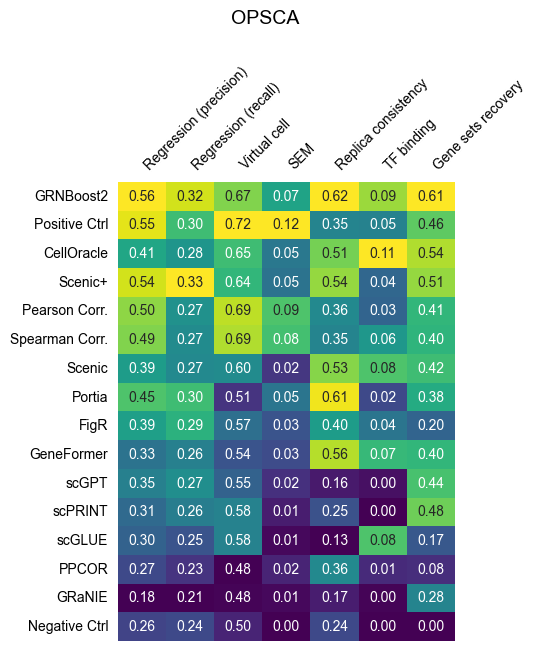

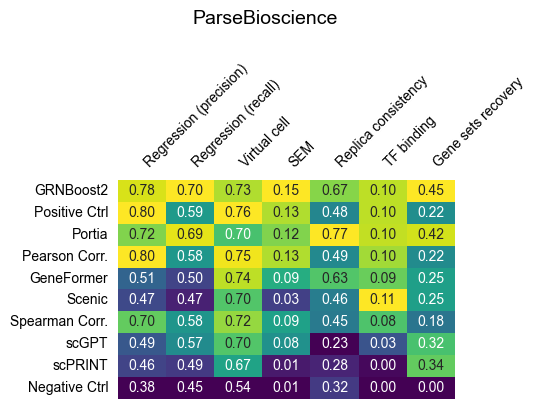

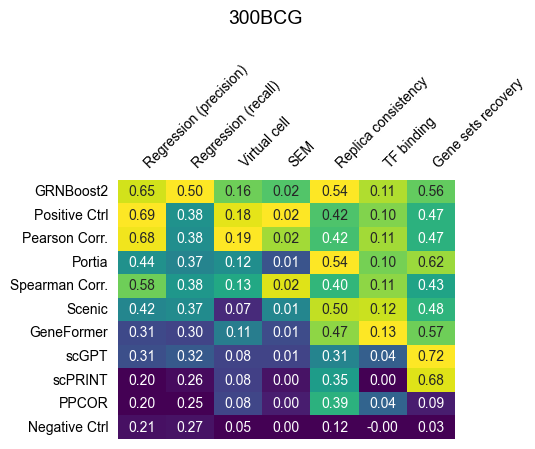

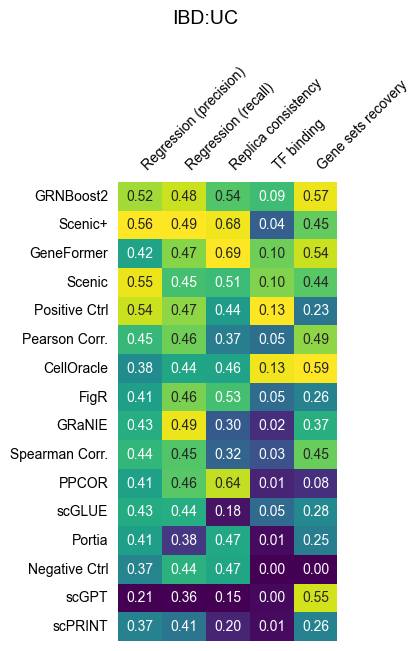

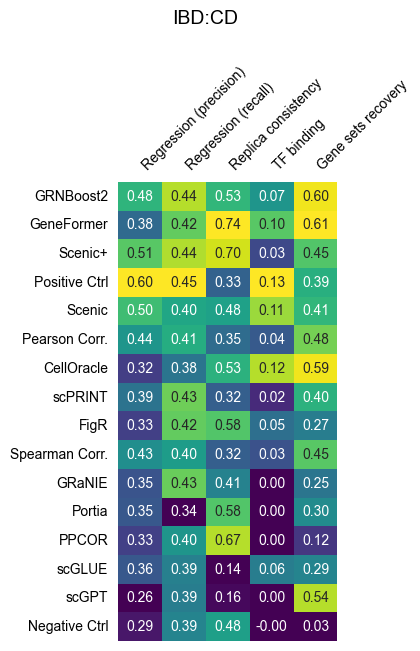

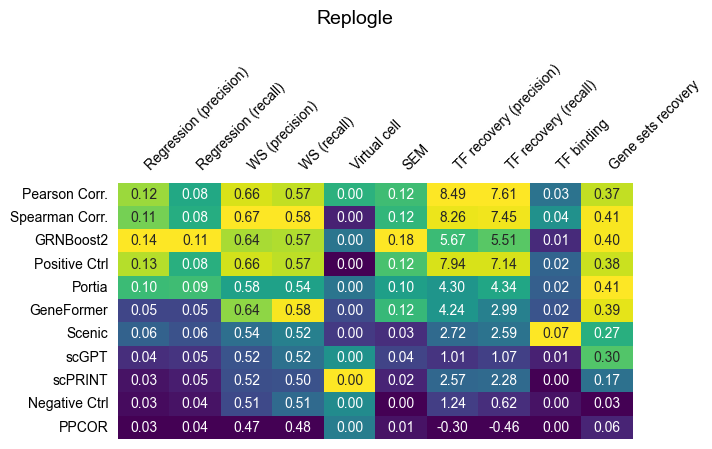

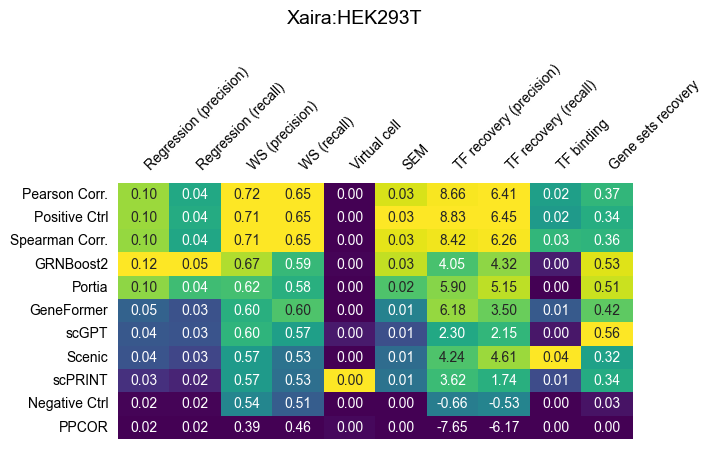

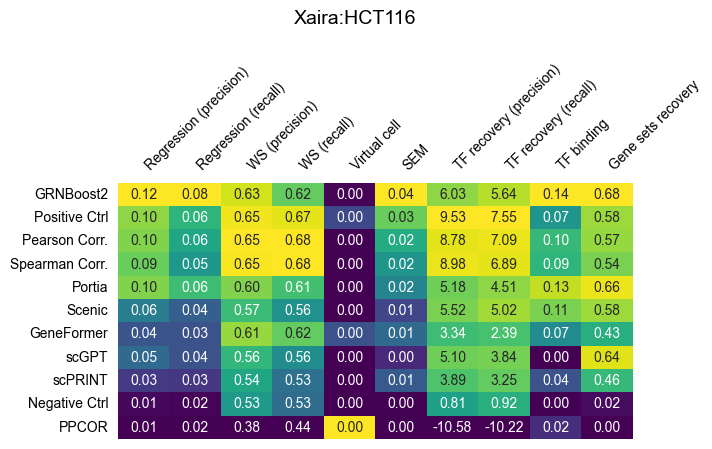

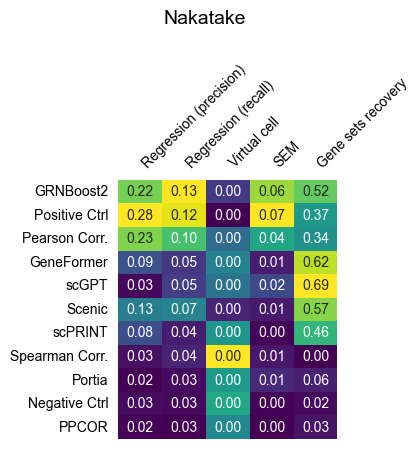

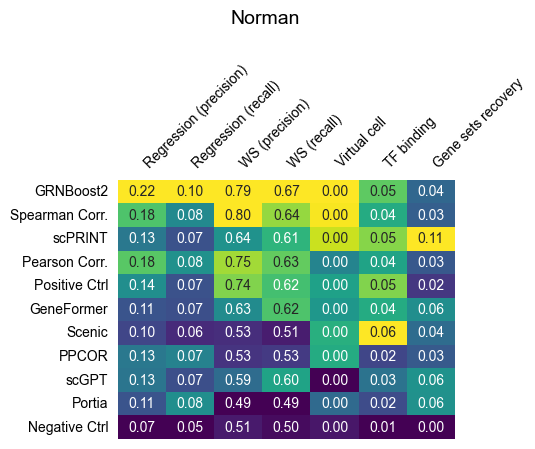

In [43]:
local_run = True
process_trace = False
datasets = DATASETS

if local_run:
    scores_all = pd.read_csv(f"{TASK_GRN_INFERENCE_DIR}/resources/results/all_scores.csv")
    scores_all = scores_all[METRICS + ['method', 'dataset']]
    scores_all.rename(columns={'method': 'model'}, inplace=True)
else:
    from src.helper import read_yaml
    
    scores_store = []
    trace_df_store = []
    for dataset in datasets: 
        scores_file = f"{TASK_GRN_INFERENCE_DIR}/resources/results/{dataset}/score_uns.yaml"
        if os.path.exists(scores_file):
            print(dataset)
            df = read_yaml(scores_file)
            df.fillna(0, inplace=True)
            scores_store.append(df)
        if process_trace:
            trace = pd.read_csv(f"{TASK_GRN_INFERENCE_DIR}/resources/results/{dataset}/trace_merged.txt", sep='\t')
            trace = process_trace_func(trace)
            trace_df_store.append(trace)
    scores_all = pd.concat(scores_store)
    scores_all.columns.name = ''
    if process_trace:
        trace_all = pd.concat(trace_df_store)
        if 'task_id' in trace_all.columns:
            trace_all = trace_all.drop(columns=['task_id'])
        if len(trace_all)>0:
            trace_all.index.name = ''
            trace_all.drop('index', axis=1, inplace=True)
        # assert scores_all['model'].unique().tolist() == trace_all['model'].unique().tolist(), "Trace data does not match expected models"
    
    scores_all = scores_all[scores_all['model'].isin(METHODS)]

if True:
    for dataset in datasets: 
        print(dataset)
        scores = scores_all[scores_all['dataset'] == dataset]
        scores = scores.loc[:, ~scores.isna().all()]
        
        n_rows = scores.shape[0]
        n_cols = scores.shape[1]
        if process_trace:
            figsize = (n_cols * 0.4, max(n_rows * 0.4, 4))
            fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=False, width_ratios=[1, 0.9])
        else:
            figsize = (n_cols * 0.6, max(n_rows * 0.4, 4))
            fig, axes = plt.subplots(1, 1, figsize=figsize, sharey=False)
        
        if True:
            ax = axes[0] if process_trace else axes
            scores = scores.set_index('model').drop(columns='dataset')
            scores = scores.dropna(how='all', axis=1)
            scores = scores[[c for c in METRICS if c in scores.columns]]
            scores.columns = scores.columns.map(lambda name: surrogate_names.get(name, name))
            scores.index = scores.index.map(lambda name: surrogate_names.get(name, name))
            scores = scores.astype(float)
            ranks = scores.rank(axis=0, ascending=False, method='min')
            scores['_overall_rank'] = ranks.mean(axis=1, skipna=True)
            scores = scores.sort_values(by='_overall_rank').drop(columns=['_overall_rank'])
            plot_heatmap(scores, name='', ax=ax, cmap="viridis")
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
            ax.set_ylabel('')
            ordered_methods = scores.index
        
        if process_trace:
            traces = trace_all[trace_all['dataset'] == dataset]
            ax = axes[1]
            trace = traces
            
            trace = trace.set_index('model').drop(columns='dataset')
            trace.index = trace.index.map(lambda name: surrogate_names.get(name, name))
            trace = trace.dropna(how='all', axis=1)
            trace = trace.loc[[c for c in ordered_methods if c in trace.index]]
            plot_heatmap(trace, name='', ax=ax, cmap="viridis")
            ax.set_ylabel('')
        
        plt.suptitle(surrogate_names.get(dataset, dataset), y=1.01, fontsize=14, weight='bold')
        plt.tight_layout()
        fig.savefig(f"{results_folder}/figs/raw_scores_{dataset}.png", dpi=200, transparent=True, bbox_inches='tight')
        fig.savefig(f"{TASK_GRN_INFERENCE_DIR}/docs/source/images/raw_scores_{dataset}.png", dpi=100, transparent=True, bbox_inches='tight')

# Overview of performance

In [3]:
!cd ../ && python scripts/combine_results.py

Processing 10 datasets: ['op', 'parsebioscience', '300BCG', 'ibd_uc', 'ibd_cd', 'replogle', 'xaira_HEK293T', 'xaira_HCT116', 'nakatake', 'norman']

1. Combining trace_merged.txt files...
  Reading trace from op...
  Reading trace from parsebioscience...
  Reading trace from 300BCG...
  Reading trace from ibd_uc...
  Reading trace from ibd_cd...
  Reading trace from replogle...
  Reading trace from xaira_HEK293T...
  Reading trace from xaira_HCT116...
  Reading trace from nakatake...
  Reading trace from norman...
  Saved combined trace to /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/all_new/trace.csv
  Total unique entries: 1439

2. Combining score_uns.yaml files...
  Reading scores from op...
  Reading scores from parsebioscience...
  Reading scores from 300BCG...
  Reading scores from ibd_uc...
  Reading scores from ibd_cd...
  Reading scores from replogle...
  Reading scores from xaira_HEK293T...
  Reading scores from xaira_HCT116...
  Reading scores from nakata

In [4]:
!cd ../ && python scripts/create_overview_figure.py

Creating Overview Figure

Using base directory: /home/jnourisa/projs/ongoing/task_grn_inference
Results folder: /home/jnourisa/projs/ongoing/task_grn_inference/resources/results
Combined directory: /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/all_new

1. Processing trace data (op dataset only)...
   Total trace entries: 1439
   positive_control: duration=0.04h, memory=11.0GB, cpu=283.9%
   pearson_corr: duration=0.04h, memory=13.2GB, cpu=1231.2%
   grnboost: duration=6.67h, memory=28.9GB, cpu=2102.6%
   ppcor: duration=5.72h, memory=25.8GB, cpu=100.1%
   portia: duration=2.96h, memory=28.9GB, cpu=188.9%
   scenic: duration=6.54h, memory=101.1GB, cpu=1991.0%
   geneformer: duration=0.24h, memory=221.7GB, cpu=102.5%
   scgpt: duration=0.10h, memory=5.7GB, cpu=101.4%
   ppcor: duration=5.72h, memory=25.8GB, cpu=100.1%
   scenicplus: duration=16.03h, memory=775.9GB, cpu=961.4%
   celloracle: duration=5.76h, memory=25.3GB, cpu=2404.8%
   figr: duration=7.63h, memory=201